In [1]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate,shift,zoom,affine_transform
from scipy.signal import convolve2d
from scipy.interpolate import griddata

In [2]:
# MILESTONE 1: Loading images
nibimgs = []
nibhdrs = []
filenames = []
for file,subdir,d in os.walk(os.getcwd()):
    if 'analyze' in file:
        filenames.append(file)
        a =[x for x in d if 'img' in x][0]
        imgpath = (os.path.join(file,a))
        nibimgs.append(imgpath)
        b = [x for x in d if 'hdr' in x][0]
        hdrpath = os.path.join(file,b)
        nibhdrs.append(hdrpath)
imgs = []
trainings_nonsegs = []
trainings_segs = []
validations_nonsegs = []
validations_segs = []
testings_nonsegs = []
testings_segs = []
training_process = []
for file in nibimgs:
    img = nib.load(file)
    hdr = img.header
    data = img.get_fdata()
    x,y,z = data.squeeze().shape
    middle_coronal = np.rot90(data[:,:,z//2],3)
    imgs.append(middle_coronal)
    p = file.index('ForClass') + len('ForClass')
    if 'training' in file.lower():
        training_process.append(file)
        if 'segmentation' in file.lower():
            trainings_segs.append([middle_coronal,file[p:]])
            print ('File (...) %s in trainings_segs'%file[p:])
        else:
            trainings_nonsegs.append([middle_coronal,file[p:]])
            print ('File (...) %s in trainings_nonsegs'%file[p:])
    elif 'testing' in file.lower():
        if 'segmentation' in file.lower():
            testings_segs.append([middle_coronal,file[p:]])
            print ('File (...) %s in testings_segs'%file[p:])
        else:
            testings_nonsegs.append([middle_coronal,file[p:]])
            print ('File (...) %s in testings_nonsegs'%file[p:])
    elif 'validation' in file.lower():
        if 'segmentation' in file.lower():
            validations_segs.append([middle_coronal,file[p:]])
            print ('File (...) %s in validations_segs'%file[p:])
        else:
            validations_nonsegs.append([middle_coronal,file[p:]])
            print ('File (...) %s in validations_nonsegs'%file[p:])
    else:
        raise ValueError ('Unidentifiable image: ',file)
        
print ('Trainings segs: ',len(trainings_segs))
print ('Trainings nonsegs: ',len(trainings_nonsegs))
print ('Validations segs: ',len(validations_segs))
print ('Validations nonsegs: ',len(validations_nonsegs))
print ('Testings segs: ',len(testings_segs))
print ('Testings nonsegs: ',len(testings_nonsegs))

print (training_process)

File (...) \Testing\IBSR_08\images\analyze\IBSR_08_ana.img in testings_nonsegs
File (...) \Testing\IBSR_09\images\analyze\IBSR_09_ana.img in testings_nonsegs
File (...) \Testing\IBSR_10\images\analyze\IBSR_10_ana.img in testings_nonsegs
File (...) \Testing\IBSR_11\images\analyze\IBSR_11_ana.img in testings_nonsegs
File (...) \Testing\IBSR_12\images\analyze\IBSR_12_ana.img in testings_nonsegs
File (...) \Testing\IBSR_13\images\analyze\IBSR_13_ana.img in testings_nonsegs
File (...) \Testing\IBSR_14\images\analyze\IBSR_14_ana.img in testings_nonsegs
File (...) \Testing\IBSR_16\images\analyze\IBSR_16_ana.img in testings_nonsegs
File (...) \Testing\IBSR_17\images\analyze\IBSR_17_ana.img in testings_nonsegs
File (...) \Training\IBSR_01\images\analyze\IBSR_01_ana.img in trainings_nonsegs
File (...) \Training\IBSR_01\segmentation\analyze\IBSR_01_seg_ana.img in trainings_segs
File (...) \Training\IBSR_02\images\analyze\IBSR_02_ana.img in trainings_nonsegs
File (...) \Training\IBSR_02\segmentati

In [3]:
def normalize(x):
    return x / np.max(x)


def my_affine_transform(img, scalex,scaley,theta,tx,ty,output_grid_shape):
#     if np.max(img) > 1:
#         print ('Image is being automatically normalized before affine transform')
#         img = normalize(img)
    if len(img.shape) > 2:
        img = np.squeeze(img)
#     shifted = shift(zoom(rotate(img,theta),[abs(scalex),abs(scaley)]),[ty,tx])
    shifted = shift(rotate(zoom(img,[abs(scalex),abs(scaley)]), theta) ,[ty,tx])
    ox, oy = shifted.shape[0]//2, shifted.shape[1]//2  
    xdim = shifted.shape[0] - output_grid_shape[0]
    ydim = shifted.shape[1] - output_grid_shape[1]
    preshape = shifted.shape
    if xdim < 0: # output grid shape x is bigger than transformed image shape x
        xdim = abs(xdim)
        shifted = np.pad(shifted,((int(np.ceil(xdim/2)),int(np.floor(xdim/2))),(0,0)),mode='constant',constant_values=0)
    if ydim < 0: # output grid shape y is bigger than transformed image shape 
        ydim = abs(ydim)
        shifted = np.pad(shifted,((0,0),(int(np.ceil(ydim/2)),int(np.floor(ydim/2)))),mode='constant',constant_values=0)
    returned = shifted[max(0,ox-output_grid_shape[0]//2):max(ox+output_grid_shape[0]//2,output_grid_shape[0]),
                       max(0,oy-output_grid_shape[1]//2):max(oy+output_grid_shape[1]//2,output_grid_shape[1])]
    
    if returned.shape[0] != output_grid_shape[0] or returned.shape[1] != output_grid_shape[1]:
        print ('ERROR')
        print ('Shape before pad: ', preshape)
        print ('Shape after pad: ',shifted.shape)
        print ('xdim,ydim : ', xdim, ydim)
        print ('Returned shape: ', returned.shape)
        print ('Output grid shape: ',output_grid_shape)
    assert returned.shape[0] == output_grid_shape[0] and returned.shape[1] == output_grid_shape[1]
    return returned.shape, returned

def geometric_transform(img, scale,theta,tx,ty,output_grid_shape):
    '''
    img (ndarray): 2-D img of floats
    scale (float): global expand/shrink, same positive factor applied on both axes
    theta (float): angle of rotation in degrees (ccw)
    tx (int): x-translation, assuming x is horizontal w.r.t user (right)
    ty (int): y-translation, assuming y is perpendicular to ground plane of user (downwards)
    '''
#     if scale < 0: 
#         raise UserWarning ('Turning scale to positive')
    shifted = shift(rotate(zoom(img.squeeze(),abs(scale)), theta) ,[ty,tx])
    
    ox, oy = shifted.shape[0]//2, shifted.shape[1]//2
    xdim = shifted.shape[0] - output_grid_shape[0]
    ydim = shifted.shape[1] - output_grid_shape[1]
    if xdim < 0: 
        xdim = abs(xdim)
        shifted = np.pad(shifted,((int(np.ceil(xdim/2)),int(np.floor(xdim/2))),(0,0)),mode='constant',constant_values=0)
    if ydim < 0: 
        ydim = abs(ydim)
        shifted = np.pad(shifted,((0,0),(int(np.ceil(ydim/2)),int(np.floor(ydim/2)))),mode='constant',constant_values=0)
    returned = shifted[max(0,ox-output_grid_shape[0]//2):max(ox+output_grid_shape[0]//2,output_grid_shape[0]),
                       max(0,oy-output_grid_shape[1]//2):max(oy+output_grid_shape[1]//2,output_grid_shape[1])]
    if returned.shape[0] != output_grid_shape[0] or returned.shape[1] != output_grid_shape[1]:
        print ('ERROR')
        print (shifted.shape)
        print (xdim, ydim)
        print (returned.shape)
        print (output_grid_shape)
    assert returned.shape[0] == output_grid_shape[0] and returned.shape[1] == output_grid_shape[1]
    return returned.shape, returned

def SSD(transform,fixed,moving,transform_type='geometric'):
    if not len(transform) == 4 and not len(transform) == 5:
        raise InvalidArgumentError
    if transform_type == 'geometric':
        transformed_moving = geometric_transform(moving.squeeze(),transform[0],transform[1],transform[2],
                                                transform[3],moving.squeeze().shape)[1]
    elif transform_type == 'affine':
        transformed_moving = my_affine_transform(moving.squeeze(),transform[0],transform[1],transform[2],
                                                transform[3],transform[4],moving.squeeze().shape)[1]
    return np.sum((transformed_moving - fixed)**2)

from scipy.optimize import fmin,fmin_powell  # uses simplex method, derivative-free
def optimize(fixed, moving, initial_guess=None, transform_type='geometric',**kwargs):
    if initial_guess is None and transform_type == 'geometric':
        initial_guess = np.array([1.1,1.1,2,3])
    elif initial_guess is None and transform_type == 'affine':
        initial_guess = np.array([1.1,1.1,1.1,2,3])
    else:
        raise InvalidArgumentError ('CHECK TRANSFORM TYPE ARGUMENT')
        initial_guess = np.array([1.1,1.1,1.1,2,3])
    optimal = fmin_powell(func=SSD,x0=initial_guess,args=(fixed,moving,transform_type),disp=True,maxiter=1e3,ftol=1e-10)
#     print ('\nOptimal parameters :')

    print (optimal)
    print ('='*60)
    if transform_type == 'geometric':
        return geometric_transform(moving,optimal[0],optimal[1],optimal[2],optimal[3],moving.shape)[1], optimal
    elif transform_type=='affine':
        return my_affine_transform(moving,optimal[0],optimal[1],optimal[2],optimal[3],optimal[4],moving.shape)[1], optimal
    else:
        pass
def jaccard(manual, automatic):
    '''
    Manual, automatic ndarray
    '''
    if len(manual.shape) > 2:
        manual = manual.squeeze()
    if len(automatic.shape) > 2: 
        automatic = automatic.squeeze()
    added = manual.astype(np.int8) + automatic.astype(np.int8)
    added = added.astype(np.int8) 
    union = (np.where(added > 0))
    intersection = (np.where(added == 2))
    return intersection[0].shape[0] / union[0].shape[0]

# print (jaccard(np.ones((2,2)),np.ones((2,2)))) # sanity check

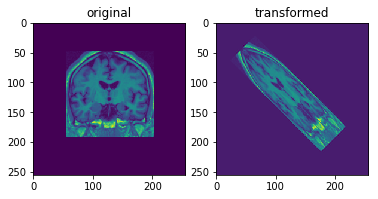

In [4]:
%matplotlib inline
test = my_affine_transform(imgs[0].squeeze(),scalex=1.5,scaley=0.4,theta=45,tx=0,ty=0,output_grid_shape=(256,256))
f,axarr = plt.subplots(1,2)
axarr[0].set_title('original')
axarr[0].imshow(imgs[0].squeeze())
axarr[1].set_title('transformed')
axarr[1].imshow(test[1])


## Optimization (MS2) change run if you need to actually use it dumbass

In [5]:
run = False
if run:
    %matplotlib inline

    init = np.array([1.5,3,1,2])
    mapping_segmentations = {}

    for i, moving in enumerate(trainings_nonsegs):
        for j, fixed in enumerate(validations_nonsegs):
            modfixed = normalize(fixed)
            modmoving = normalize(moving)
    #         equalfixed  = cv2.equalizeHist(modfixed)
    #         equalmoving = cv2.equalizeHist(modmoving)
    #         clahefixed = clahe.apply(modfixed)
    #         clahemoving = clahe.apply(modmoving)

            optimal_transform, params = optimize(modfixed,modmoving,initial_guess=init)

            # Make gridpoints and interpolate between optimal transform and validation grid
            xx, yy = np.meshgrid(np.arange(fixed.shape[0]),np.arange(fixed.shape[1]),indexing='ij')
            fixedcoords = np.vstack([ xx.reshape(-1), yy.reshape(-1)]).T
            xx, yy = np.meshgrid(np.arange(optimal_transform.shape[0]),np.arange(optimal_transform.shape[1]),indexing='ij')
            optcoords = np.vstack([ xx.reshape(-1), yy.reshape(-1)]).T
            a = griddata(points=optcoords,values=optimal_transform.flatten(),xi=fixedcoords,method='nearest').reshape(fixed.squeeze().shape)

            mapping_segmentations[(i,j)] = [a, params] # store optimal transform in dict
            #  Plot results

            f, axarr = plt.subplots(1,3,figsize=(20,20))

            axarr[0].set_title('Original Training %d' %i)
            axarr[0].imshow(modmoving.squeeze())

            axarr[1].set_title('Validation %d' %j)
            axarr[1].imshow(modfixed.squeeze())

    #         axarr[2].set_title('Optimized Transformed')
    #         axarr[2].imshow(optimal_transform)

            axarr[2].set_title('Interpolated Optimized Transform of Training')
            axarr[2].imshow(a)        
            plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.55,
                        wspace=0.35)
            plt.show()

        

## Majority Voting Based Label Fusion

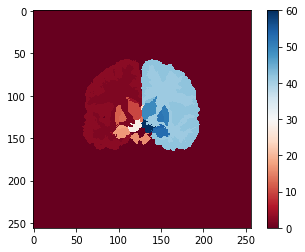

In [6]:
%matplotlib inline
# Majority based labeling 
from scipy.stats import mode
# Ties broken by choosing smaller label (default scipy operation)

def majority_fusion(segs_list): 
    votes = mode(np.dstack(segs_list),axis=2)
    return votes[0].squeeze()

training_majority_labs = majority_fusion([trainings_segs[i][0] for i in range(len(trainings_segs))])
plt.imshow(training_majority_labs,cmap='RdBu')
plt.colorbar()



## Exploring Histogram Equalization

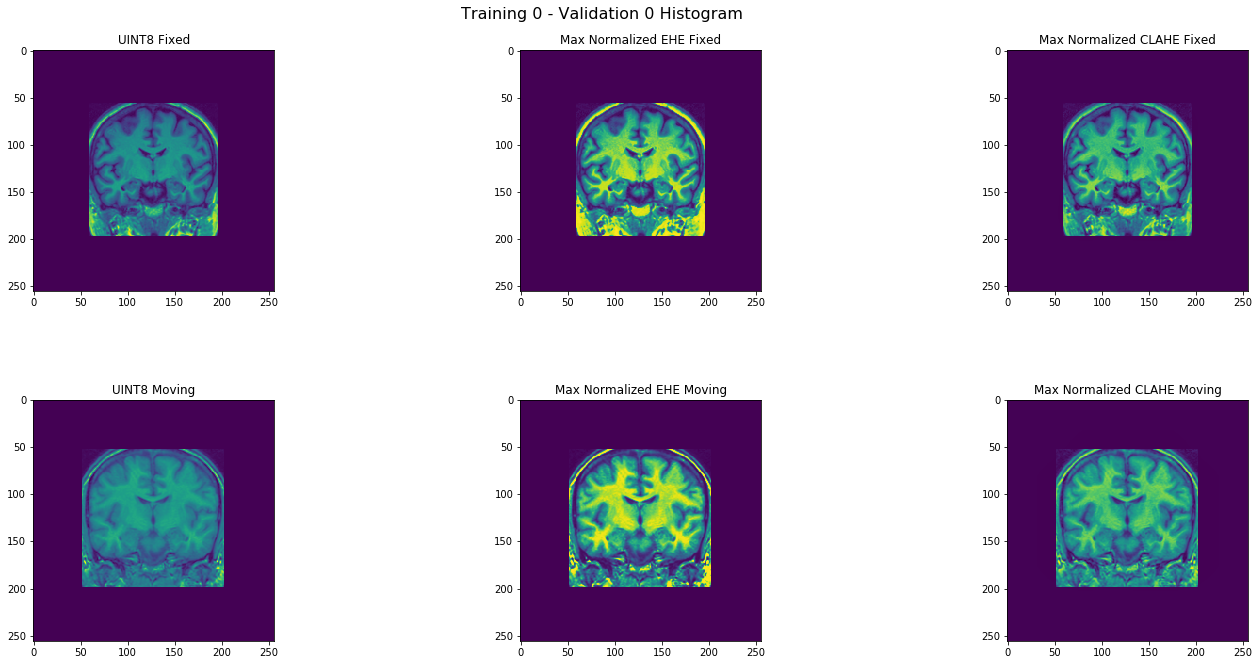

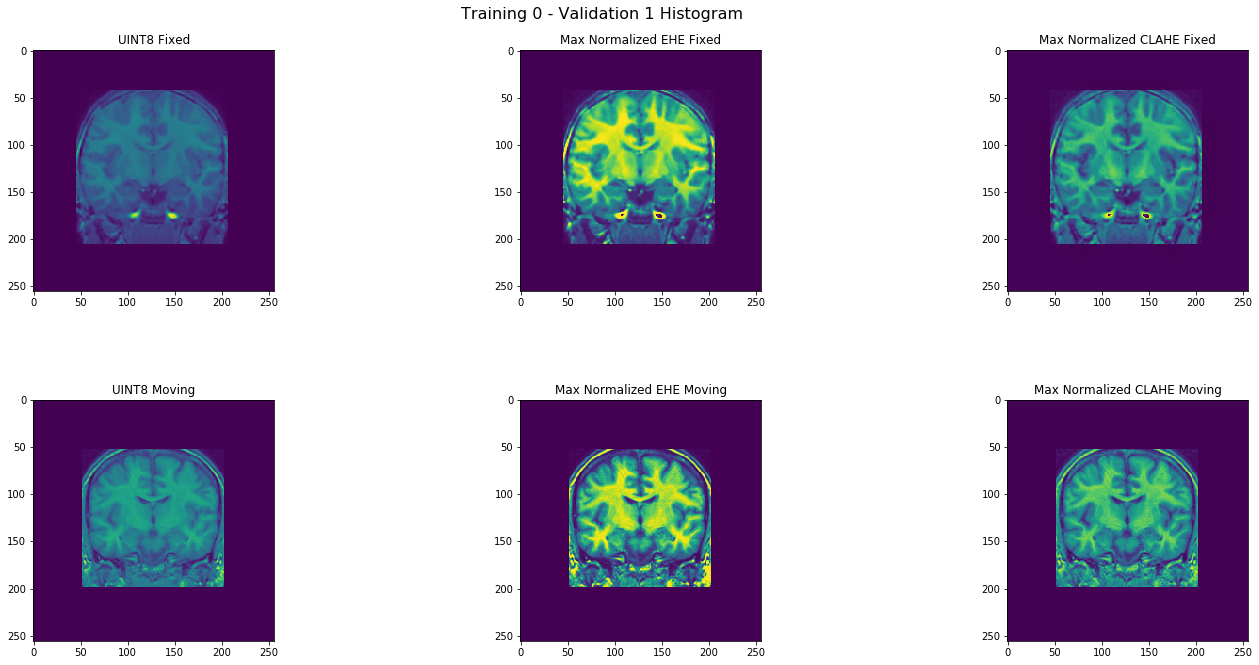

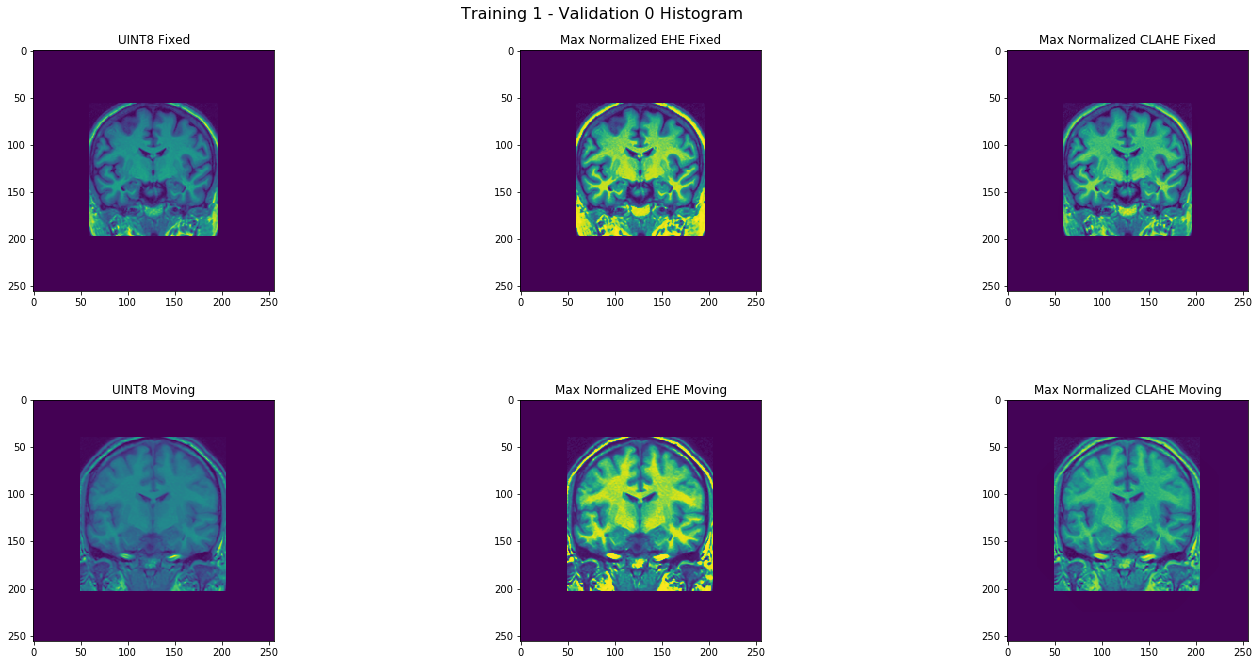

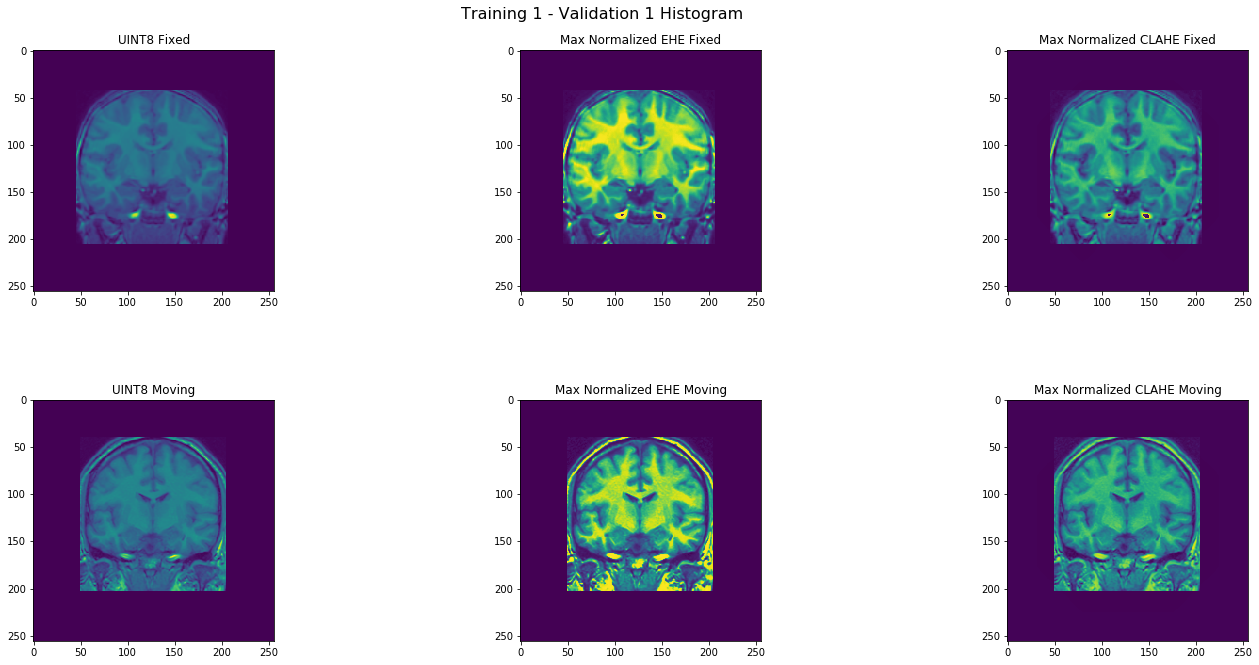

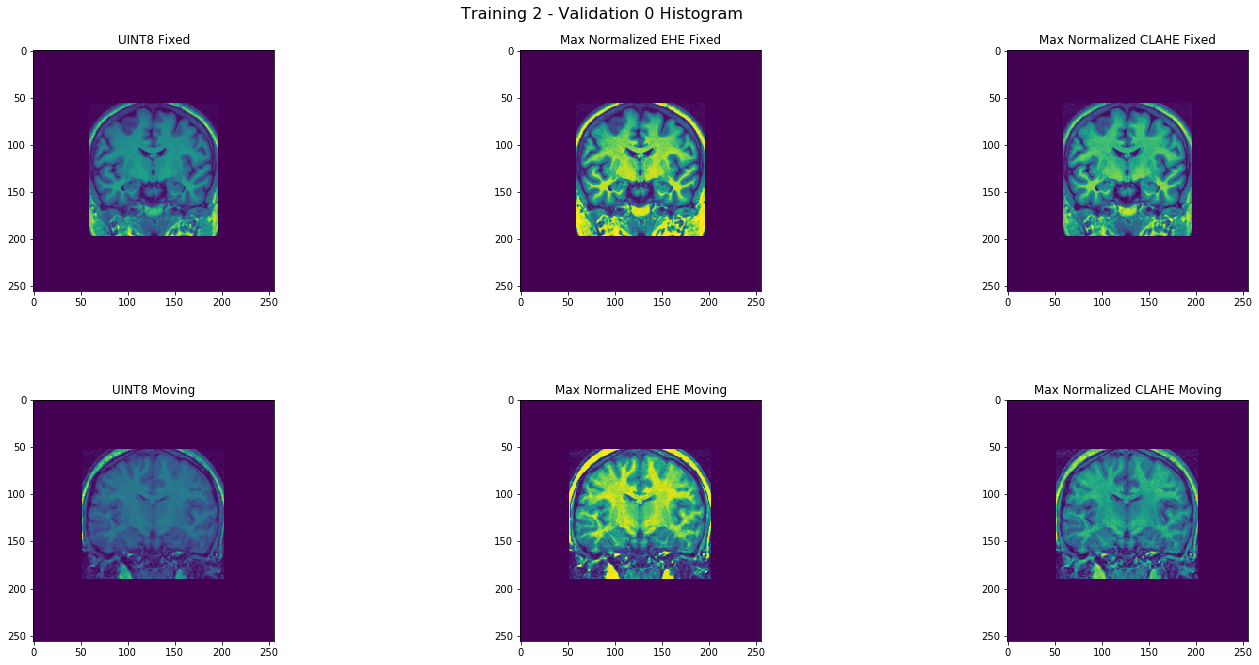

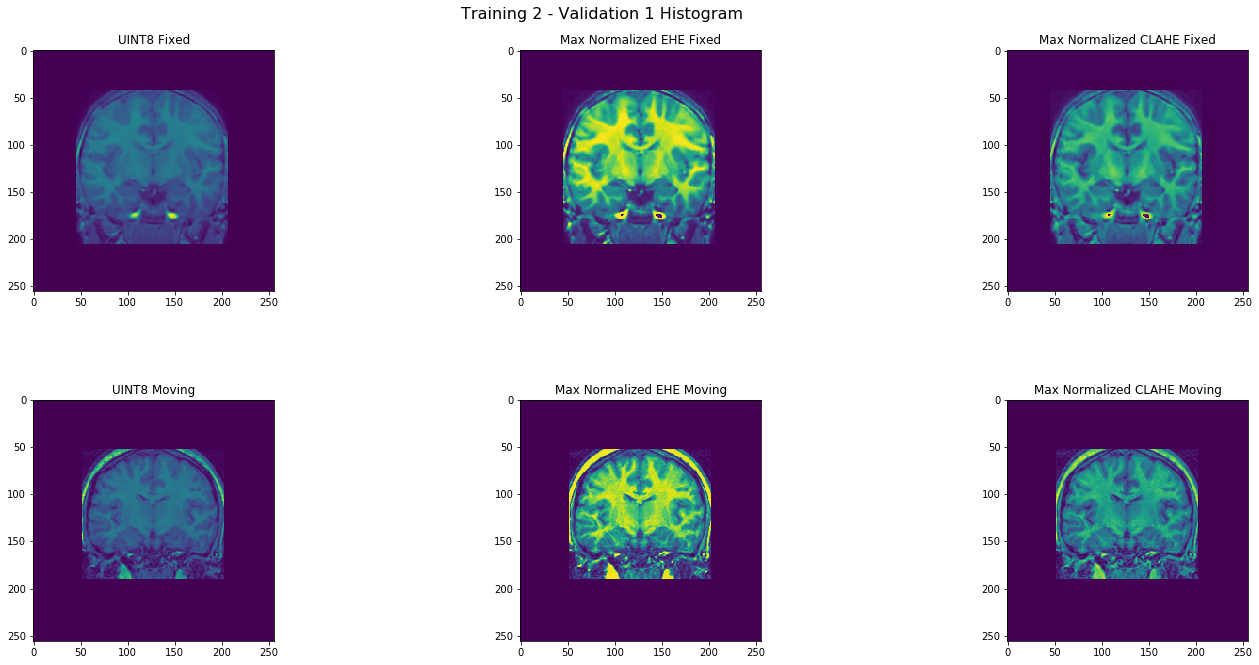

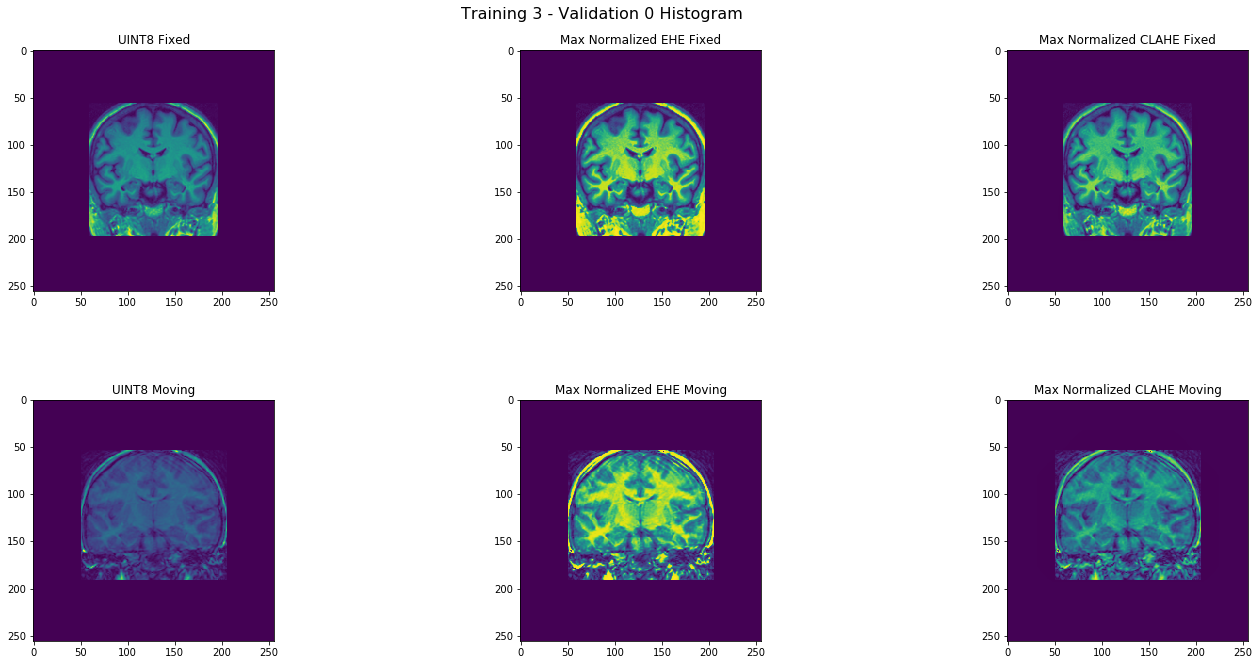

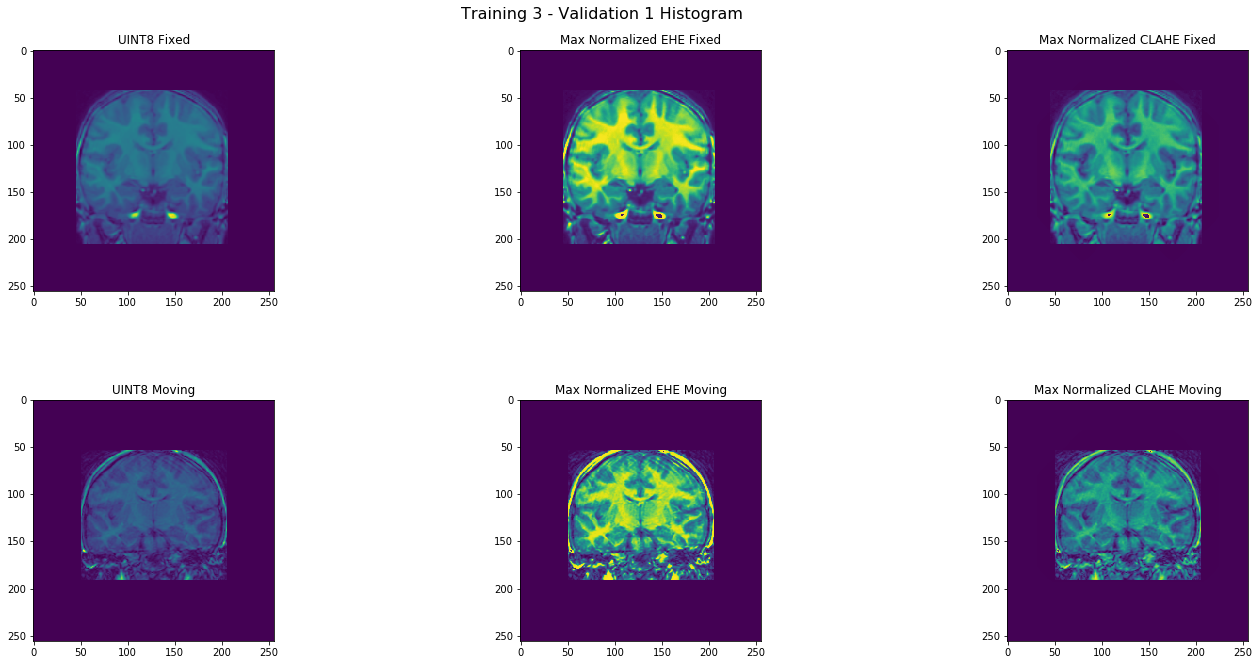

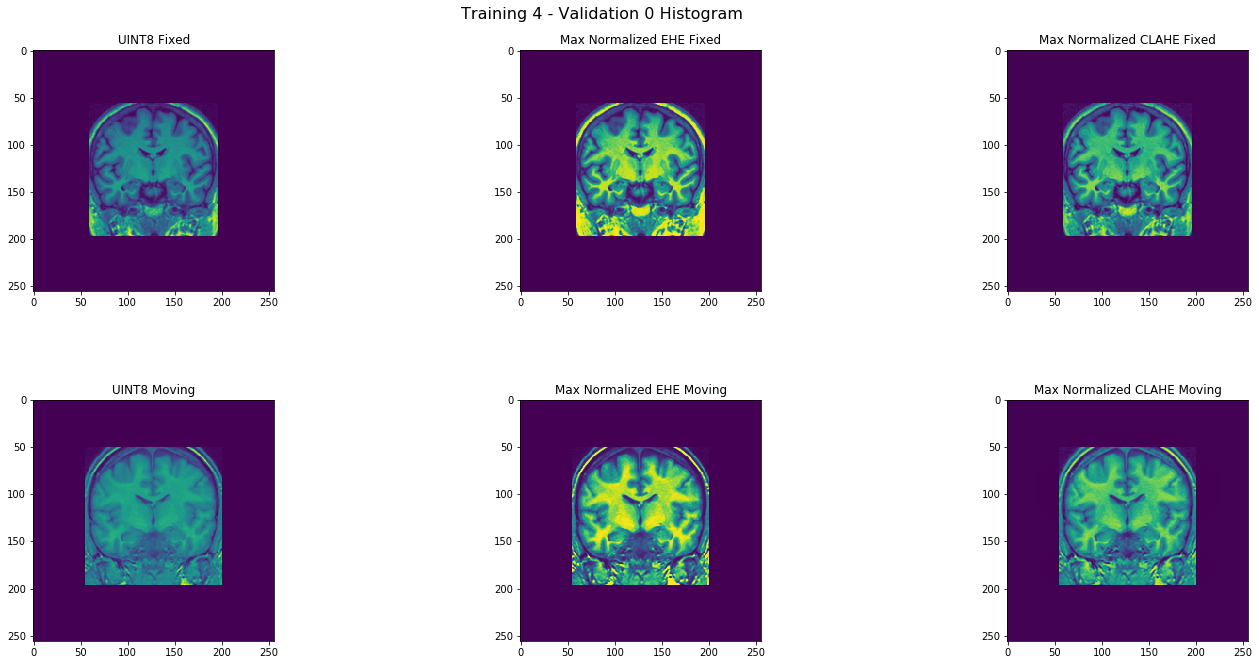

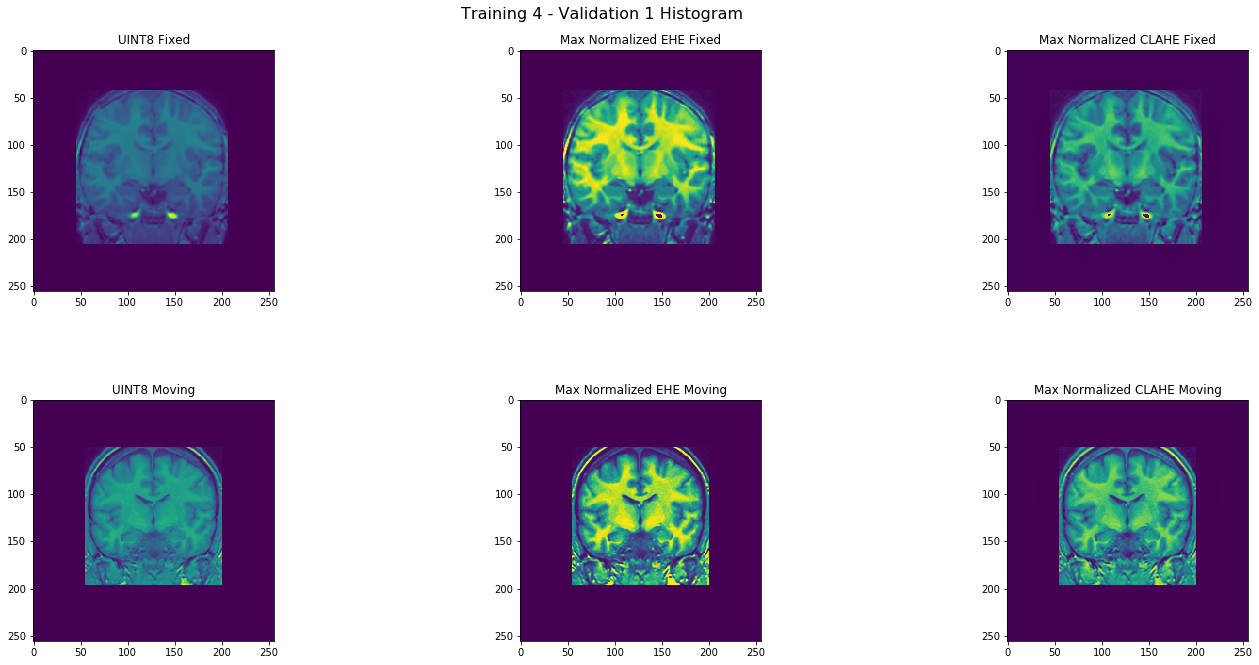

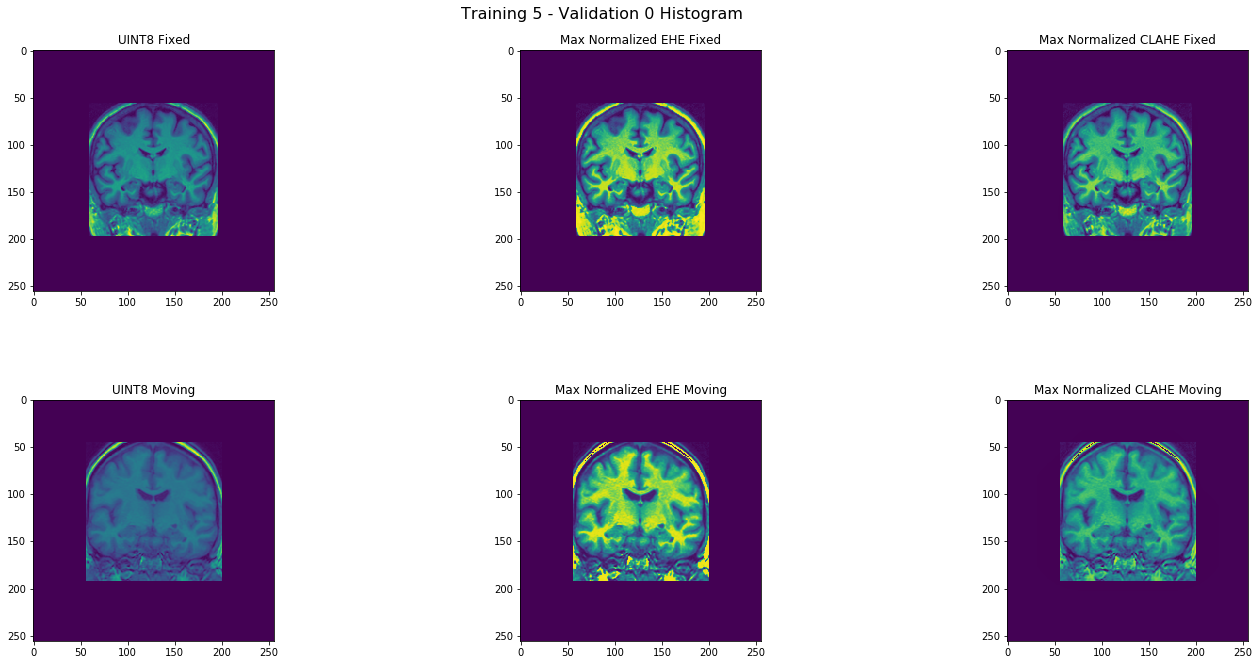

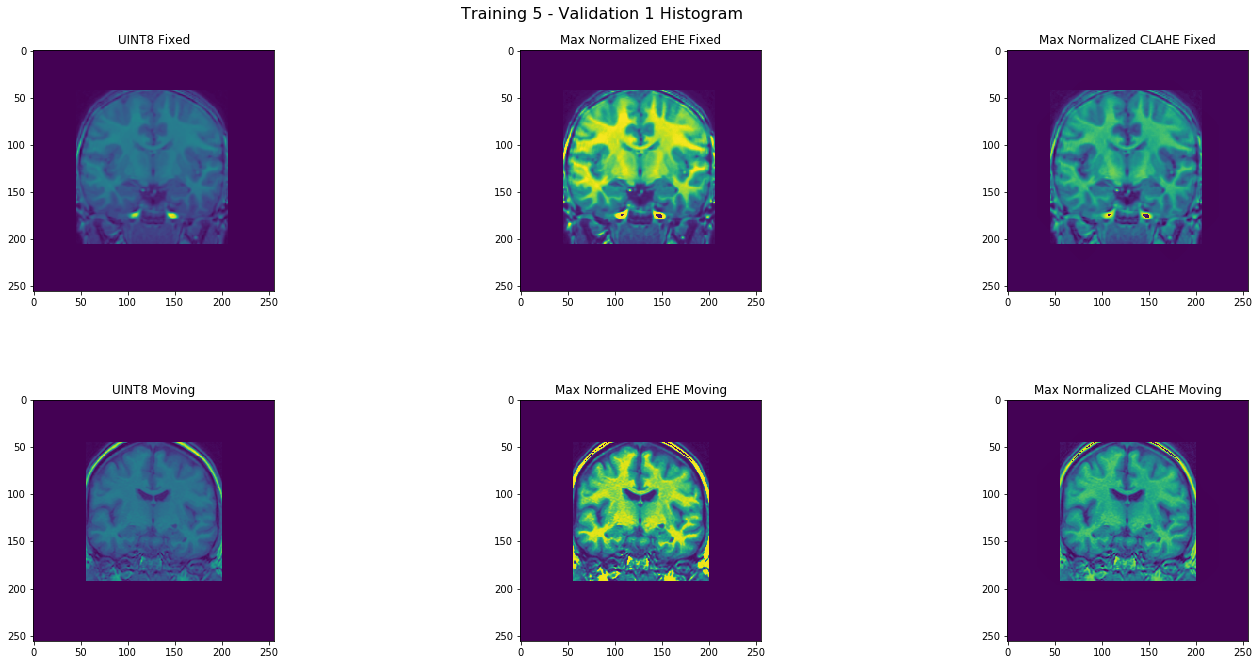

In [7]:
import cv2
clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8,8)) #OG: 2.0, (8,8)
for i, moving in enumerate(trainings_nonsegs):
    for j, fixed in enumerate(validations_nonsegs):
        modfixed = (fixed[0].squeeze())
        modmoving = (moving[0].squeeze())
        
        equalfixed  = normalize(cv2.equalizeHist((modfixed).astype(np.uint8)))
        equalmoving = normalize(cv2.equalizeHist((modmoving).astype(np.uint8)))
        clahefixed = normalize(clahe.apply((modfixed).astype(np.uint8)))
        clahemoving = normalize(clahe.apply((modmoving).astype(np.uint8)))
        f, axarr = plt.subplots(2,3,figsize=(20,10))
        f.suptitle('Training %d - Validation %d Histogram '%(i,j), fontsize=16)
        axarr[0][0].set_title('UINT8 Fixed')
        s = axarr[0][0].imshow(modfixed)  
        axarr[0][1].set_title('Max Normalized EHE Fixed')
        axarr[0][1].imshow(equalfixed)
        axarr[0][2].set_title('Max Normalized CLAHE Fixed')
        axarr[0][2].imshow(clahefixed)  
        axarr[1][0].set_title('UINT8 Moving')
        s = axarr[1][0].imshow(modmoving)  
        axarr[1][1].set_title('Max Normalized EHE Moving')
        axarr[1][1].imshow(equalmoving)
        axarr[1][2].set_title('Max Normalized CLAHE Moving')
        axarr[1][2].imshow(clahemoving)  

        
        
        plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.45,
                    wspace=0.95)
        plt.plot()
        plt.show()


In [8]:
# # Optimization sanity check
# params, timg = my_affine_transform(trainings_nonsegs[0],1.3,0.8,45,3,5,trainings_nonsegs[0].shape)
# tximg, params = optimize(trainings_nonsegs[0],timg,
#          transform_type='affine')
# f, axarr = plt.subplots(1,3,figsize=(20,10))
# axarr[0].set_title('Original')
# axarr[0].imshow(trainings_nonsegs[0].squeeze())
# axarr[1].set_title('Transformed')
# axarr[1].imshow(timg)
# axarr[2].set_title('Optimal transform applied')
# axarr[2].imshow(tximg)
# # the latter two should be identical

In [9]:
def map_segmentations(trainings_nonsegs,validations_nonsegs,histo=None,view=False):
    mapping_segmentations = {}

    for i, moving in enumerate(trainings_nonsegs):
        for j, fixed in enumerate(validations_nonsegs):
            modfixed = fixed[0].squeeze().astype(np.uint8)
            modmoving = moving[0].squeeze().astype(np.uint8)
            if histo is not None: 
                modfixed = histo.apply(modfixed.astype(np.uint8))
                modmoving = histo.apply(modmoving.astype(np.uint8))
            optimal_transform, params = optimize(fixed=normalize(modfixed),
                                                 moving=(normalize(modmoving)),
                                                 initial_guess=None,
                                                 transform_type='affine')
            xx, yy = np.meshgrid(np.arange(fixed[0].shape[0]),np.arange(fixed[0].shape[1]),indexing='ij')
            fixedcoords = np.vstack([ xx.reshape(-1), yy.reshape(-1)]).T
            xx, yy = np.meshgrid(np.arange(optimal_transform.shape[0]),np.arange(optimal_transform.shape[1]),indexing='ij')
            optcoords = np.vstack([ xx.reshape(-1), yy.reshape(-1)]).T
            a = griddata(points=optcoords,
                         values=optimal_transform.flatten(),
                         xi=fixedcoords
                         ,method='nearest').reshape(fixed[0].squeeze().shape)


            mapping_segmentations[(i,j)] = params # store optimal transform in dict
            #  Plot results

            if view: 
                f, axarr = plt.subplots(2,3,figsize=(20,10))
                f.suptitle('CLAHE Adaptive Histogram Transform Applied Before Optimization')
                axarr[0][0].set_title('Original Fixed')
                s = axarr[0][0].imshow(modfixed)  
                axarr[0][1].set_title('CLAHE Transform Fixed')
                axarr[0][1].imshow(clahefixed)
                axarr[0][2].set_title('Optimized')
                axarr[0][2].imshow(optimal_transform)
                axarr[1][0].set_title('Original Moving')
                s = axarr[1][0].imshow(modmoving)  
                axarr[1][1].set_title('CLAHE Histogram Moving')
                axarr[1][1].imshow(clahemoving)
                axarr[1][2].set_title('Interpolated Optimized')
                axarr[1][2].imshow(a)




                plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.45,
                            wspace=0.95)
                plt.plot()
                plt.show()
        return mapping_segmentations

In [10]:
%matplotlib inline
def compute_jacs(mapping_segmentations,label_dict,trainings_segs,validations_segs,view=False):
    table = []
    for label in list(label_dict.keys()):
#         print ('Computing Jaccard Overlap for %s\n======================================\n'%label_dict[label])
        for valid in range(len(validations_segs)):
            manualcopy = np.copy(validations_segs[valid][0].squeeze())
            autocopy = np.zeros_like(manualcopy)
            segment_transforms = []
    #         print (np.unique(manualcopy))
            for mapping, params in mapping_segmentations.items():  #mapping [0] is training, mapping [1] is valid
                if mapping[1] == valid: 
    #                 print (validations_segs[valid][1] , ' REGISTERED TO ', trainings_nonsegs[mapping[0]][1])
    #                 print ('TRANSFORMING ', trainings_segs[mapping[0]][1])
    #                 print (np.unique(trainings_segs[mapping[0]][0].squeeze()))
    #                 print (trainings_segs[mapping[0]][0].shape)
#                     p = np.max(trainings_segs[mapping[0]][0])  # used for reversing effect of normalization
    #                 print ('Max label: ',p)
                    seg_transform =  my_affine_transform((trainings_segs[mapping[0]][0].squeeze().astype(np.uint8)),
                                                            params[0],
                                                            params[1],
                                                            params[2],
                                                            params[3],
                                                            params[4],
                                                            trainings_segs[mapping[0]][0].squeeze().shape)[1]
                    segment_transforms.append(seg_transform.astype(np.int16))
    #                 print (np.unique(seg_transform.astype(np.int16)))
            if view: 
                f, axarr = plt.subplots(2,6,figsize=(10,4))
                f.suptitle('Segmentation transforms output for Trainings to Validation %d'%(mapping[1]))
                for i in range(6):
                    for j in range(2):
                        if j == 0:
                            axarr[j][i].imshow(segment_transforms[i])
                        elif j == 1:
                            segcopy = np.zeros_like(segment_transforms[i])
                            segcopy[np.where(segment_transforms[i]==label)] = 1
                            segcopy[np.where(segcopy!=1)] = 0
                            axarr[j][i].imshow(segcopy)
                        else:
                            pass

                plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.45, wspace=0.95)
                plt.plot()
                plt.show()

            voted = majority_fusion(segment_transforms)

            autocopy[np.where(voted==label)] = 1
            autocopy[np.where(autocopy != 1)] = 0
            manualcopy[np.where(manualcopy == label)] = 1
            manualcopy[np.where(manualcopy != 1)] = 0
            assert autocopy.shape == manualcopy.shape and manualcopy.shape == voted.shape
            if view: 
                f, axarr = plt.subplots(1,3,figsize=(20,20))

                axarr[0].set_title('Majority Voted Label ROI %s'%label_dict[label])
                s = axarr[0].imshow(voted)  
                axarr[1].set_title('Manual Segment ROI Val Subject %d: %s'%(valid,label_dict[label]))
                axarr[1].imshow(manualcopy)
                axarr[2].set_title('Automated Segment ROI %s'%label_dict[label])
                axarr[2].imshow(autocopy)  
                plt.subplots_adjust(top=0.92, bottom=0.10, left=0.10, right=0.95, hspace=0.45, wspace=0.95)
                plt.plot()
                plt.show()
            jac = jaccard(manualcopy,autocopy)
    #         print ('Jaccard Overlap: ', jac)
            manualcopy = np.zeros_like(autocopy)
            table.append([valid,label_dict[label],jac]) #  validation subjects x labels
    return table


In [11]:
import pandas as pd
space = '\n'+'=' * 30
for clipLimit in [1.0,1.25,1.50,1.75,2.0,2.25,2.5]:
    for grid in [2,4,6,8,10]:
        print ('ClipLimit=%f, GridSize=%d %s'%(clipLimit,grid,space))
        label_dict = {2:'Left White Matter', 3:'Left Cerebral Cortex', 41:'Right White Matter',42:'Right Cerebral Cortex'}
        histo = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(grid,grid)) #OG: 2.0, (8,8)
        mapping_segmentations =map_segmentations(trainings_nonsegs,validations_nonsegs,histo=histo,view=False)
        jacs = compute_jacs (mapping_segmentations, label_dict,trainings_segs,validations_segs,view=False)
        print (pd.DataFrame(jacs,columns=['Valid','ROI','Score']))

ClipLimit=1.000000, GridSize=2 


C:\Users\shubh\Anaconda3\envs\python36\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Optimization terminated successfully.
         Current function value: 739.606354
         Iterations: 10
         Function evaluations: 962
[ 0.94936272  0.90604373  0.00955948 -0.20606364  1.921631  ]
Optimization terminated successfully.
         Current function value: 941.310691
         Iterations: 8
         Function evaluations: 773
[ 1.07302824  1.05419605 -1.25813112 -1.24343155 -0.49082228]
Computing Jaccard Overlap for Left White Matter

Computing Jaccard Overlap for Left Cerebral Cortex

Computing Jaccard Overlap for Right White Matter

Computing Jaccard Overlap for Right Cerebral Cortex



NameError: name 'pd' is not defined

In [ ]:
import pandas as pd
''' 
MS 2 RESULTS:
   Validation Subject             ROI(label)  Jaccard Score
0                   0      Left White Matter       0.266126
1                   1      Left White Matter       0.230147
2                   0   Left Cerebral Cortex       0.110977
3                   1   Left Cerebral Cortex       0.071576
4                   0     Right White Matter       0.469211
5                   1     Right White Matter       0.426517
6                   0  Right Cerebral Cortex       0.239431
7                   1  Right Cerebral Cortex       0.124970

'''
print (pd.DataFrame(table,columns=['Val','ROI','Jaccard Overlap']))